In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
np.random.seed(123)

## Generating exogenous and endogenous

In [19]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [20]:
Time = np.arange(0,200)

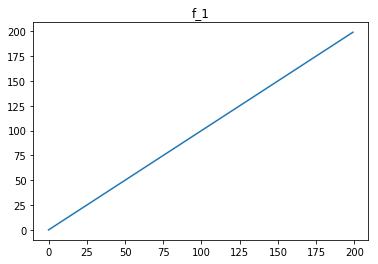

In [21]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

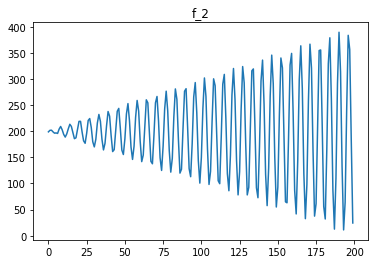

In [22]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

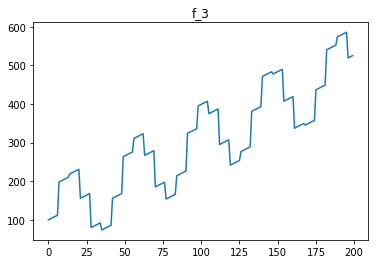

In [23]:
plt.plot(Time,f_3(Time, period=7))
plt.title("f_3")
plt.show()

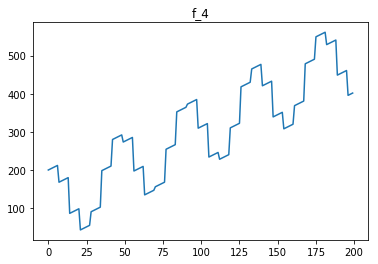

In [24]:
plt.plot(Time,f_4(Time,period=7))
plt.title("f_4")
plt.show()

In [25]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis =1)

In [26]:
Exog.shape

(200, 4)

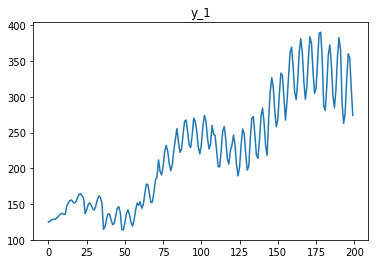

In [27]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

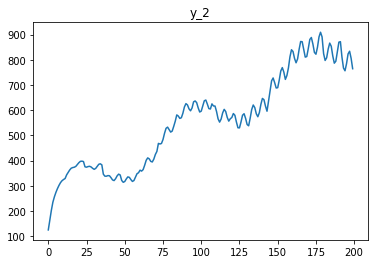

In [28]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

In [29]:
def plot_results(clue,y,forecast):
    plt.figure(figsize=(10,7))
    l1 = plt.plot(Time,y,label = 'observed')
    l2 = plt.plot(Time, forecast, label = 'forecasted')
    observed_test = y[100:]
    forecast_test = forecast[100:]
    plt.title("df{}: MAPE = {}, MAE ={}".format(clue,mean_absolute_percentage_error(observed_test.squeeze(),
                                                                                    forecast_test.squeeze()),
                                               mean_absolute_error(observed_test,forecast_test)))
    plt.axvline(x=100, color = 'red')
    plt.legend()
    plt.grid()
    plt.show()

### Auto-arima (Pyramid) without exog

In [30]:
import pyramid
import math
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from sklearn import metrics
import pandas as pd
from pyramid.arima import auto_arima

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [32]:
train_data_1 = y_1[:100]
test_data_1 = y_1[100:]
train_data_2 = y_2[:100]
test_data_2 = y_2[100:]
exog_train = Exog[:100]
exog_test = Exog[100:]

## Stepwise

In [33]:
stepwise_fit_1 = auto_arima(train_data_1, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, max_d=4, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,
                          stepwise=True)  # set to stepwise

stepwise_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(5, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -326.863
Date:                            Tue, 10 Jul 2018   AIC                            671.726
Time:                                    18:33:49   BIC                            695.082
Sample:                                         0   HQIC                           681.176
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1739      0.526      0.331      0.741      -0.857       1.204
ar.L1          0.7800      0.472      1.653      0.098      -0.145       1.705
ar.L2         -0.2325      0.258     -0.902      0.367      -0.738       0.273
ar.L3         -0.1820      0.181     -1.005      0.315      -0.537       0.173
ar.L4         -0.0300      0.198     -0.152      0.879      -0.417       0.357
ar.L5          0.3273      0.133      2.452      0.014       0.066       0.589
ma.L1         -0.6213      0.493     -1.261      0.207      -1.587       0.344
ar.S.L12       0.4845      0.070      6.924      0.000       0.347       0.622
sigma2        40.8966      3.893     10.506      0.000      33.267      48.526
===================================================================================
Ljung-Box (Q):                       95.50   Jarque-Bera (JB):               206.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.59
Prob(H) (two-sided):                  0.16   Kurtosis:                         9.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

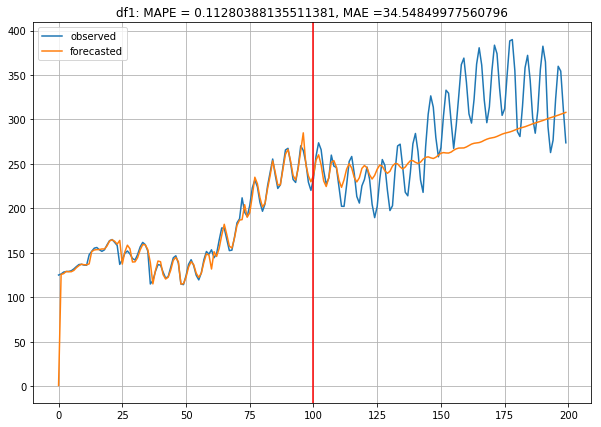

In [34]:
in_sample_preds_st1 = stepwise_fit_1.predict_in_sample()
next_validate_st1 = stepwise_fit_1.predict(n_periods=100)
plot_results(1,y_1,np.concatenate([in_sample_preds_st1,next_validate_st1]))

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data_1,next_validate_st1)

34.54849977560796

In [36]:
stepwise_fit_2 = auto_arima(train_data_2, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, max_d=4, max_D=2,max_P = 5, max_Q = 5, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit_2.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=789.321, BIC=794.511, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=702.174, BIC=712.554, Fit time=0.094 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=745.854, BIC=753.639, Fit time=0.045 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=608.593, BIC=621.568, Fit time=0.365 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=579.729, BIC=595.300, Fit time=0.627 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=683.761, BIC=696.737, Fit time=0.417 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=573.302, BIC=59

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(3, 1, 2)x(2, 0, 0, 12)   Log Likelihood                -226.622
Date:                            Tue, 10 Jul 2018   AIC                            471.243
Time:                                    18:34:03   BIC                            494.599
Sample:                                         0   HQIC                           480.693
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0385      0.087      0.445      0.656      -0.131       0.208
ar.L1          2.0448      0.015    136.399      0.000       2.015       2.074
ar.L2         -2.0423      0.015   -134.175      0.000      -2.072      -2.013
ar.L3          0.9744      0.009    103.838      0.000       0.956       0.993
ma.L1         -0.7873      0.077    -10.248      0.000      -0.938      -0.637
ma.L2          0.8597      0.054     15.891      0.000       0.754       0.966
ar.S.L12       1.0732      0.014     77.548      0.000       1.046       1.100
ar.S.L24      -0.9865      0.004   -227.841      0.000      -0.995      -0.978
sigma2         1.9653      0.291      6.742      0.000       1.394       2.537
===================================================================================
Ljung-Box (Q):                       40.22   Jarque-Bera (JB):               138.95
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.31
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

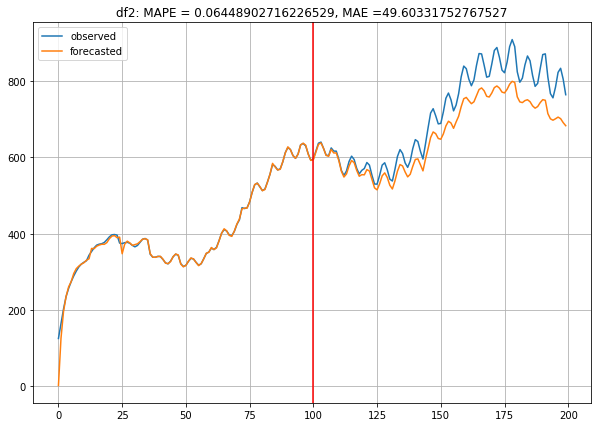

In [37]:
in_sample_preds_st2 = stepwise_fit_2.predict_in_sample()
next_validate_st2 = stepwise_fit_2.predict(n_periods=100)
plot_results(2,y_2,np.concatenate([in_sample_preds_st2,next_validate_st2]))

### Random search

In [38]:
rs_fit_1 = auto_arima(train_data_1,start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                    start_P=0, n_jobs=-1, max_d=4, max_D=2,max_P = 5, max_Q = 5, trace=True,
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=42, n_fits = 200)

rs_fit_1.summary()

Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(4, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 5) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_orde

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(3, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 5) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(4, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_orde

Fit ARIMA: order=(5, 1, 3) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(5, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(3, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 5) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 1) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 3)x(3, 0, 1, 12)   Log Likelihood                -180.268
Date:                            Tue, 10 Jul 2018   AIC                            382.536
Time:                                    18:34:35   BIC                            411.082
Sample:                                         0   HQIC                           394.086
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7148      0.124     13.865      0.000       1.472       1.957
ar.L1          1.0648      0.021     51.174      0.000       1.024       1.106
ar.L2         -0.9867      0.011    -89.772      0.000      -1.008      -0.965
ma.L1         -1.0324      0.182     -5.684      0.000      -1.388      -0.676
ma.L2          0.4257      0.236      1.805      0.071      -0.037       0.888
ma.L3         -0.0047      0.225     -0.021      0.983      -0.446       0.437
ar.S.L12       0.4345      0.095      4.572      0.000       0.248       0.621
ar.S.L24      -0.3025      0.104     -2.899      0.004      -0.507      -0.098
ar.S.L36      -0.6356      0.093     -6.831      0.000      -0.818      -0.453
ma.S.L12       0.4747      0.150      3.166      0.002       0.181       0.769
sigma2         0.7133      0.197      3.617      0.000       0.327       1.100
===================================================================================
Ljung-Box (Q):                       92.53   Jarque-Bera (JB):               587.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -2.00
Prob(H) (two-sided):                  0.09   Kurtosis:                        14.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

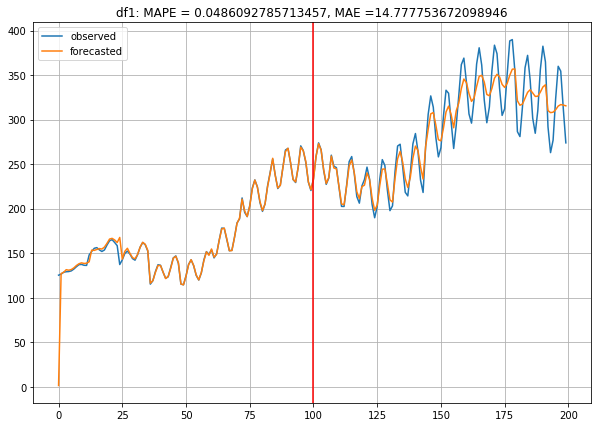

In [39]:
in_sample_preds_1 = rs_fit_1.predict_in_sample()
next_validate_1 = rs_fit_1.predict(n_periods=100)
plot_results(1,y_1,np.concatenate([in_sample_preds_1,next_validate_1]))

In [40]:
rs_fit_2 = auto_arima(train_data_2,start_p=1, start_q=1, max_p=5, max_q=5,m=12,
                    start_P=0, n_jobs=-1, max_d=4, max_P=5, max_D=2, max_Q=5, trace=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                    n_fits=200)

rs_fit_2.summary()

Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 5) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(3, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5) seasonal_orde

Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=652.072, BIC=670.238, Fit time=1.352 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 5, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(4, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 0, 1, 12); AIC=648.524, BIC=669.285, Fit time=1.557 seconds
Fit ARIMA: order=(1,

Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 4) seasonal_order=(0, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(4, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(3, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 4, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5, 1, 3) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(1, 0, 3, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 3) seasonal_order=(1, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(4, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(3, 1, 2)x(2, 0, 1, 12)   Log Likelihood                -231.641
Date:                            Tue, 10 Jul 2018   AIC                            483.282
Time:                                    18:35:32   BIC                            509.233
Sample:                                         0   HQIC                           493.782
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2472      0.255      0.970      0.332      -0.252       0.747
ar.L1          2.0191      0.062     32.687      0.000       1.898       2.140
ar.L2         -2.0145      0.066    -30.664      0.000      -2.143      -1.886
ar.L3          0.9476      0.061     15.437      0.000       0.827       1.068
ma.L1         -0.6595      0.054    -12.181      0.000      -0.766      -0.553
ma.L2          0.9099      0.083     10.987      0.000       0.748       1.072
ar.S.L12       1.0795      0.014     79.649      0.000       1.053       1.106
ar.S.L24      -0.9907      0.003   -325.652      0.000      -0.997      -0.985
ma.S.L12      -0.9753      1.194     -0.817      0.414      -3.315       1.364
sigma2         1.6193      1.810      0.895      0.371      -1.928       5.167
===================================================================================
Ljung-Box (Q):                       63.89   Jarque-Bera (JB):               110.29
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.04
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

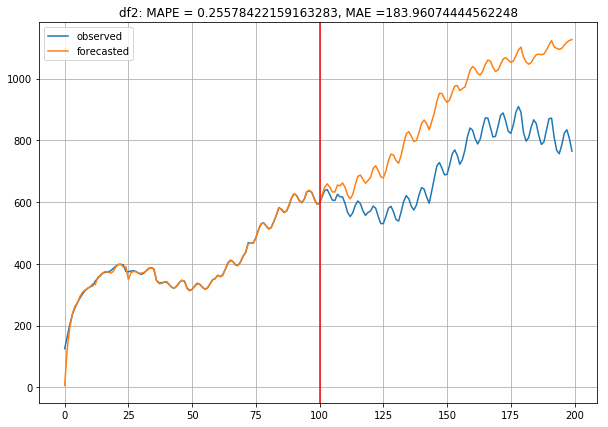

In [41]:
in_sample_preds_2 =rs_fit_2.predict_in_sample()
next_validate_2 = rs_fit_2.predict(n_periods=100)
plot_results(2,y_2,np.concatenate([in_sample_preds_2,next_validate_2]))

# Pyramid (with exog)

## Stepwise

In [42]:
stepwise_fit_1_e = auto_arima(train_data_1,exogenous=exog_train, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, max_d=4, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,
                          stepwise=True)  # set to stepwise

stepwise_fit_1_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(0, 0, 1, 12)   Log Likelihood                2975.230
Date:                            Tue, 10 Jul 2018   AIC                          -5934.459
Time:                                    18:35:34   BIC                          -5913.618
Sample:                                         0   HQIC                         -5926.024
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.618e-15   8.17e-15      0.565      0.572   -1.14e-14    2.06e-14
x1             0.2500   7.51e-16   3.33e+14      0.000       0.250       0.250
x2             0.2500   9.47e-17   2.64e+15      0.000       0.250       0.250
x3             0.2500   1.91e-16   1.31e+15      0.000       0.250       0.250
x4             0.2500   1.51e-16   1.66e+15      0.000       0.250       0.250
ar.L1          0.7835   1.41e-19   5.55e+18      0.000       0.783       0.783
ma.S.L12       0.6269    1.3e-19   4.81e+18      0.000       0.627       0.627
sigma2      8.775e-28   2.14e-10    4.1e-18      1.000   -4.19e-10    4.19e-10
===================================================================================
Ljung-Box (Q):                      105.35   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               1.19   Skew:                            -0.11
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.51e+34. Standard errors may be unstable.
"""

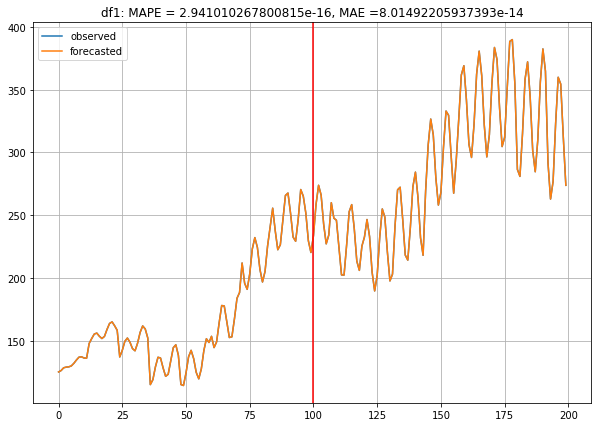

In [43]:
in_sample_preds_st1_e = stepwise_fit_1_e.predict_in_sample(exogenous=exog_train)
next_validate_st1_e = stepwise_fit_1_e.predict(n_periods=100, exogenous= exog_test)
plot_results(1,y_1,np.concatenate([in_sample_preds_st1_e,next_validate_st1_e]))

In [44]:
stepwise_fit_2_e = auto_arima(train_data_2,exogenous=exog_train, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, max_d=4, max_D = 2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit_2_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 0, 1)x(2, 0, 0, 12)   Log Likelihood                -172.171
Date:                            Tue, 10 Jul 2018   AIC                            366.341
Time:                                    18:35:58   BIC                            394.998
Sample:                                         0   HQIC                           377.939
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2405      0.567     -0.424      0.671      -1.351       0.870
x1             4.5363      1.899      2.388      0.017       0.814       8.259
x2             0.2044      0.011     17.847      0.000       0.182       0.227
x3             0.2069      0.005     45.584      0.000       0.198       0.216
x4             0.2102      0.003     69.744      0.000       0.204       0.216
ar.L1          1.9617      0.010    187.168      0.000       1.941       1.982
ar.L2         -0.9746      0.012    -81.417      0.000      -0.998      -0.951
ma.L1          0.8882      0.042     21.178      0.000       0.806       0.970
ar.S.L12       1.3583      0.066     20.503      0.000       1.228       1.488
ar.S.L24      -0.7627      0.047    -16.195      0.000      -0.855      -0.670
sigma2         1.1790      0.217      5.430      0.000       0.753       1.605
===================================================================================
Ljung-Box (Q):                       99.43   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.00   Prob(JB):                         0.93
Heteroskedasticity (H):               0.40   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

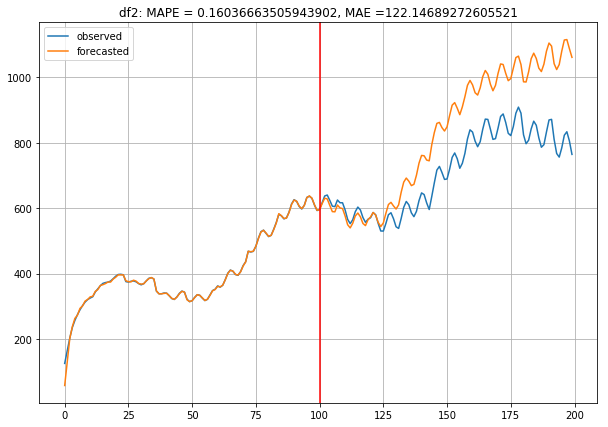

In [45]:
in_sample_preds_st2_e = stepwise_fit_2_e.predict_in_sample(exogenous = exog_train)
next_validate_st2_e = stepwise_fit_2_e.predict(n_periods=100, exogenous=exog_test)
plot_results(2,y_2,np.concatenate([in_sample_preds_st2_e,next_validate_st2_e]))

### Random search

In [46]:
rs_fit_1_e = auto_arima(train_data_1,exogenous=exog_train,start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                    start_P=0, n_jobs=-1, max_d=4, max_D=2,max_P = 5, max_Q = 5, trace=False,
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=42, n_fits = 200 )

rs_fit_1_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                2979.846
Date:                            Tue, 10 Jul 2018   AIC                          -5939.691
Time:                                    18:36:28   BIC                          -5913.640
Sample:                                         0   HQIC                         -5929.148
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.094e-15    4.3e-15      1.419      0.156   -2.33e-15    1.45e-14
x1             0.2500   6.57e-16   3.81e+14      0.000       0.250       0.250
x2             0.2500   1.23e-16   2.04e+15      0.000       0.250       0.250
x3             0.2500   1.21e-16   2.07e+15      0.000       0.250       0.250
x4             0.2500   1.18e-16   2.12e+15      0.000       0.250       0.250
ar.L1          0.6702   1.66e-19   4.04e+18      0.000       0.670       0.670
ma.L1          0.2954   2.39e-19   1.24e+18      0.000       0.295       0.295
ar.S.L12       0.7100   1.98e-19   3.58e+18      0.000       0.710       0.710
ma.S.L12      -0.1709   1.24e-19  -1.37e+18      0.000      -0.171      -0.171
sigma2      8.459e-28    2.2e-10   3.85e-18      1.000   -4.31e-10    4.31e-10
===================================================================================
Ljung-Box (Q):                       66.27   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.01   Prob(JB):                         0.67
Heteroskedasticity (H):               1.60   Skew:                             0.05
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.91e+34. Standard errors may be unstable.
"""

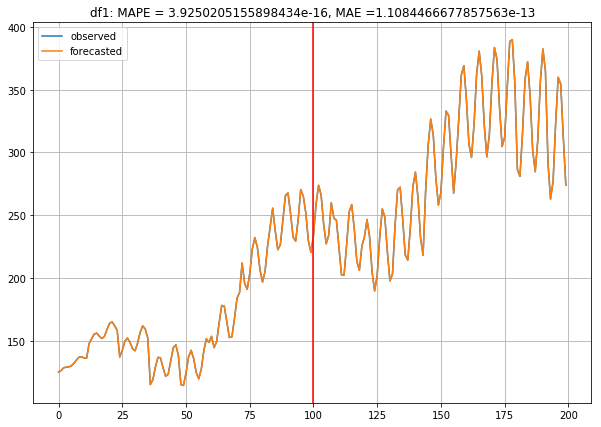

In [47]:
in_sample_preds_1_e = rs_fit_1_e.predict_in_sample(exogenous=exog_train)
next_validate_1_e = rs_fit_1_e.predict(n_periods=100, exogenous=exog_test)
plot_results(1,y_1,np.concatenate([in_sample_preds_1_e,next_validate_1_e]))

In [48]:
rs_fit_2_e = auto_arima(train_data_2,exogenous=exog_train,start_p=1, start_q=1, max_p=5, max_q=5,m=12,
                    start_P=0, n_jobs=-1, max_d=4, max_P=5, max_D=2, max_Q=5, trace=False,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                    n_fits=200)

rs_fit_2_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(5, 0, 1)x(3, 0, 1, 12)   Log Likelihood                -167.000
Date:                            Tue, 10 Jul 2018   AIC                            365.999
Time:                                    18:37:46   BIC                            407.682
Sample:                                         0   HQIC                           382.869
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2488      1.094      0.227      0.820      -1.895       2.392
x1             4.5714      2.297      1.990      0.047       0.069       9.073
x2             0.2014      0.014     14.605      0.000       0.174       0.228
x3             0.2133      0.007     30.100      0.000       0.199       0.227
x4             0.2114      0.007     29.032      0.000       0.197       0.226
ar.L1          1.9764      0.104     18.915      0.000       1.772       2.181
ar.L2         -0.5559      0.195     -2.850      0.004      -0.938      -0.174
ar.L3         -1.4176      0.064    -21.984      0.000      -1.544      -1.291
ar.L4          1.5455      0.184      8.381      0.000       1.184       1.907
ar.L5         -0.5585      0.098     -5.724      0.000      -0.750      -0.367
ma.L1          0.9794      0.057     17.143      0.000       0.867       1.091
ar.S.L12       0.5790      0.759      0.763      0.445      -0.908       2.066
ar.S.L24       0.1502      0.959      0.157      0.876      -1.730       2.030
ar.S.L36      -0.5201      0.609     -0.855      0.393      -1.713       0.673
ma.S.L12       0.8310      0.689      1.206      0.228      -0.519       2.181
sigma2         0.9079      0.180      5.037      0.000       0.555       1.261
===================================================================================
Ljung-Box (Q):                       69.49   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               0.33   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

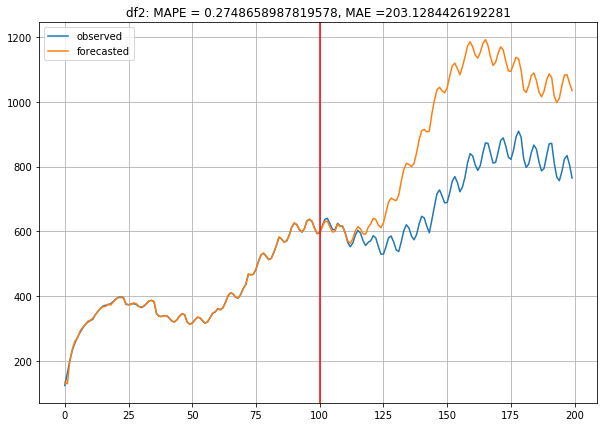

In [49]:
in_sample_preds_2_e =rs_fit_2_e.predict_in_sample(exogenous = exog_train)
next_validate_2_e = rs_fit_2_e.predict(n_periods=100, exogenous = exog_test)
plot_results(2,y_2,np.concatenate([in_sample_preds_2_e,next_validate_2_e]))

# PyAF (1)

In [50]:
import pyaf.ForecastEngine as autof
import pandas as pd

In [51]:
Time_dt = pd.date_range(start = '01/01/2018', periods = 200, freq="M")

In [52]:
df = pd.DataFrame({"Date": Time_dt, "Y": y_1.squeeze()})

In [53]:
data_train_for_pyfa = df.iloc[:100]

### Without exog

In [54]:
lEngine = autof.cForecastEngine()
lEngine.train(data_train_for_pyfa, 'Date' , 'Y',100);
#lEngine.getModelInfo()

INFO:pyaf.std:START_TRAINING 'Y'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Y' 10.385945081710815


In [55]:
forecast_df = lEngine.forecast(data_train_for_pyfa, 100);
#forecast_df[['Date' , 'Y' , 'Y_Forecast']].tail(50)

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 7.831482172012329


In [56]:
predictions_pyfa = np.array(forecast_df['Y_Forecast'])
#print (predictions_pyfa)

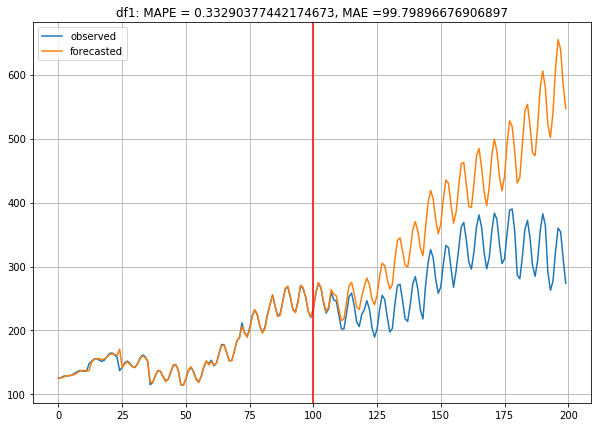

In [57]:
plot_results(1,y_1,predictions_pyfa)

# PyAF (2)

In [58]:
import pyaf.ForecastEngine as autof
import pandas as pd

In [59]:
Time_dt = pd.date_range(start = '01/01/2018', periods = 200, freq="M")

In [60]:
df_2 = pd.DataFrame({"Date": Time_dt, "Y": y_2.squeeze()})

In [61]:
data_train_for_pyfa_2 = df_2.iloc[:100]

### Without exog

In [62]:
lEngine_2 = autof.cForecastEngine()
lEngine_2.train(data_train_for_pyfa_2, 'Date' , 'Y',100);
#lEngine_2.getModelInfo()

INFO:pyaf.std:START_TRAINING 'Y'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Y' 10.419893980026245


In [63]:
forecast_df_2 = lEngine_2.forecast(data_train_for_pyfa_2, 100);
#forecast_df_2[['Date' , 'Y' , 'Y_Forecast']].tail(50)

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 8.094414949417114


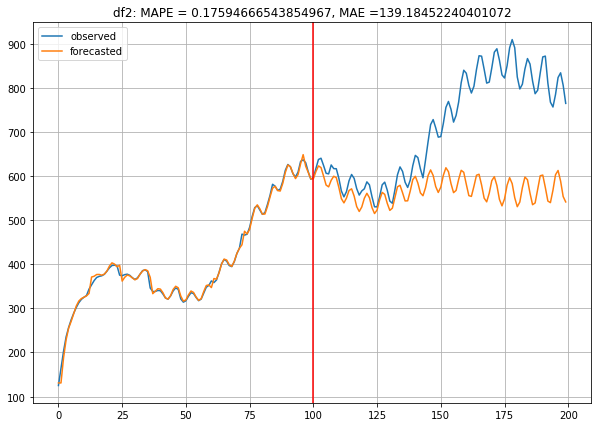

In [64]:
predictions_pyfa_2 = np.array(forecast_df_2['Y_Forecast'])
#print (predictions_pyfa_2)
plot_results(2,y_2,predictions_pyfa_2)

# PyAF (with exog)

In [65]:
exog_dataframe = pd.DataFrame({"Date": Time_dt, "Exog_1": Exog[:,0].squeeze(),
                              "Exog_2": Exog[:,1].squeeze(),"Exog_3": Exog[:,2].squeeze(),
                               "Exog_4": Exog[:,3].squeeze()})

In [66]:
exog_dataframe.head()

,Date,Exog_1,Exog_2,Exog_3,Exog_4
0,2018-01-31,0.0,200.703310,100.0,200.0
1,2018-02-28,1.0,200.243366,102.0,202.0
2,2018-03-31,2.0,204.019297,104.0,204.0
3,2018-04-30,3.0,201.111657,106.0,206.0
4,2018-05-31,4.0,196.966483,108.0,208.0


In [67]:
import pyaf.ForecastEngine as autof
lEngine_exog = autof.cForecastEngine()


lExogenousData = (exog_dataframe , ['Exog_1' , 'Exog_2' , 'Exog_3',  'Exog_4']) 

lEngine_exog.train(data_train_for_pyfa, 'Date' , 'Y', 100 , lExogenousData);

INFO:pyaf.std:START_TRAINING 'Y'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Y' 13.236256122589111


In [68]:
#lEngine_exog.getModelInfo()

In [69]:
forecast_df_1_exog = lEngine_exog.forecast(data_train_for_pyfa, 100);

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 8.448414325714111


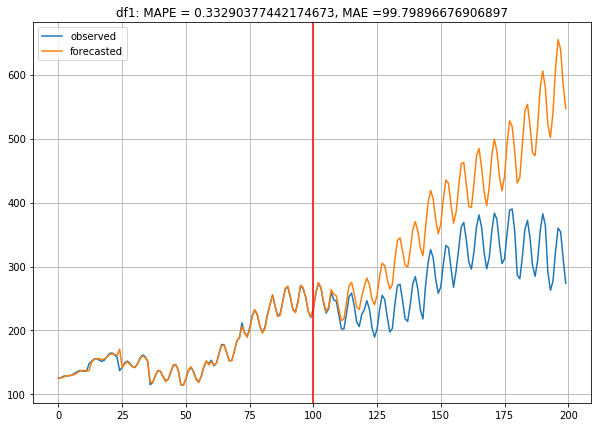

In [70]:
predictions_pyfa_1_exog = np.array(forecast_df_1_exog['Y_Forecast'])
plot_results(1,y_1,predictions_pyfa_1_exog)

# PyAF (with exog)

In [71]:
import pyaf.ForecastEngine as autof
lEngine_exog_2 = autof.cForecastEngine()

lEngine_exog_2.train(data_train_for_pyfa_2, 'Date' , 'Y',100 , lExogenousData);

INFO:pyaf.std:START_TRAINING 'Y'
INFO:pyaf.std:END_TRAINING_TIME_IN_SECONDS 'Y' 17.59478998184204


In [72]:
#lEngine_exog_2.getModelInfo()

In [73]:
forecast_df_2_exog = lEngine_exog_2.forecast(data_train_for_pyfa_2, 100);

INFO:pyaf.std:START_FORECASTING
INFO:pyaf.std:END_FORECAST_TIME_IN_SECONDS 14.131820440292358


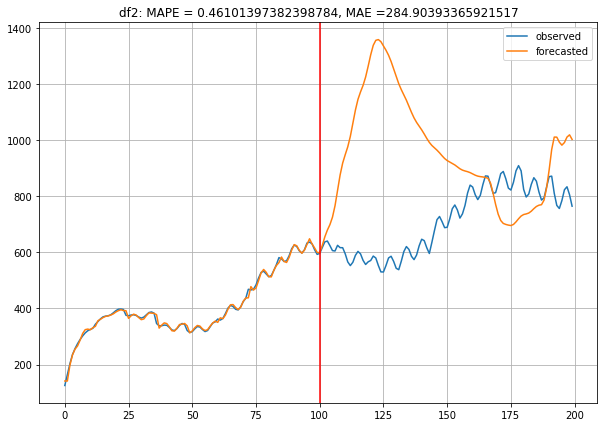

In [74]:
predictions_pyfa_2_exog = np.array(forecast_df_2_exog['Y_Forecast'])
plot_results(2,y_2,predictions_pyfa_2_exog)